In [4]:
import numpy as np
import string
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import itertools
import functools
from functools import reduce
#import enchant
#from english_words import english_words_set
#from pptx import Presentation
import io

### 14-segment display

![title](digital_chars.gif)

In [5]:
# 14-segment digital display representations. 

# These are the representations according to the GIF above, 
# but keep in mind that there might be multiple possible representations
# for a given character. 

letters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

# in alphabetical order
strokes = [
    {1, 2, 6, 7, 8, 9, 13}, #A
    {1,4,6,8,11,13,14},     #B
    {1,2,9,14},             #C
    {1,4,6,11,13,14},       #D
    {1,2,7,8,9,14},         #E
    {1,2,7,8,9},            #F
    {1,2,8,9,13,14},        #G
    {2,6,7,8,9,13},         #H
    {1,4,11,14},            #I
    {6,9,13,14},            #J
    {2,5,7,9,12},           #K
    {2,9,14},               #L
    {2,3,5,6,9,13},         #M
    {2,3,6,9,12,13},        #N
    {1,2,6,9,13,14},        #O
    {1,2,6,7,8,9},          #P
    {1,2,6,9,12,13,14},     #Q
    {1,2,6,7,8,9,12},       #R
    {1,3,8,13,14},          #S
    {1,4,11},               #T
    {2,6,9,13,14},          #U
    {2,5,9,10},             #V
    {2,6,9,10,12,13},       #W
    {3,5,10,12},            #X
    {3,5,11},               #Y
    {1,5,10,14}             #Z
]

## Representations of characters

In [6]:
# convert a set of segment indices (e.g. {3,5,11} to a 14-dim binary array format)
def display_to_rep(display):
    a = np.zeros(14)
    for i in display:
        a[i-1] = 1
    return a

In [7]:
# convert a letter to a 14-dim binary array format
def get_letter_rep(letter):
    if letter not in letters:
        raise ValueError("Not a valid letter.")
    idx = letters.index(letter)
    strokelist = strokes[idx]
    a = np.zeros(14)
    for i in strokelist:
        a[i-1] = 1
    return a

get_letter_rep("Z")

array([1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.])

In [8]:
def rep_to_display(rep):
    a = set()
    for i in range(len(rep)):
        if rep[i] == 1:
            a.add(i)
    return a
        

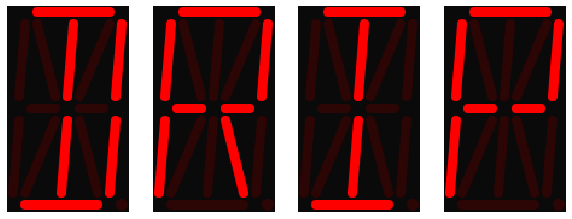

In [97]:
# function to plot a given word
def plot_word(word):
    fig, ax = plt.subplots(1, len(word), figsize=(10, 5))
    
    imageObject = Image.open("digital_chars.gif")
    for i, char in enumerate(word.upper()):
        imageObject.seek(letters.index(char))
        j = ax[i].imshow(imageObject)
        ax[i].axis('off')
        
plot_word('drip')

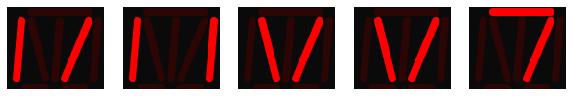

In [96]:
# function to plot a given word
def plot_word_masked(word, level_of_occlusion = 4):
    fig, ax = plt.subplots(1, len(word), figsize=(10, 5))
    
    imageObject = Image.open("digital_chars.gif")
    for i, char in enumerate(word.upper()):
        if char != " ":
            width, height = imageObject.size
            left = 0
            right = width
            top = 0
            #bottom = height/2
            bottom=height
            if level_of_occlusion == 3:
                bottom = height-30
            if level_of_occlusion == 2:
                bottom=height/2
            if level_of_occlusion == 1:
                bottom=height/2-30
            if level_of_occlusion == 0:
                bottom=10
            imageObject.seek(letters.index(char))
            ax[i].imshow(imageObject.crop((left, top, right, bottom)))
            ax[i].axis('off')
        else:
            blankObject = Image.open("blank segment picture.png")
            ax[i].imshow(blankObject)
            ax[i].axis('off')
            
        
plot_word_masked('VWXYZ', 2)

In [37]:
# convert letter to a set of segment indices, e.g. Y -> {3,5,11}
def get_letter_display(letter):
    if letter not in letters:
        raise ValueError("Not a valid letter.")
    idx = letters.index(letter)
    return strokes[idx]

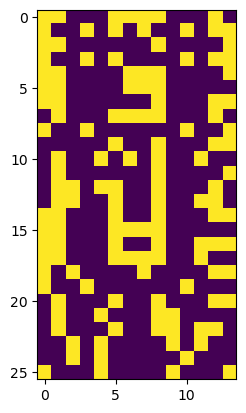

In [8]:
# 26 letters of the alphabet, each having a 14-bit representation
reps = np.array([get_letter_rep(x) for x in letters])
plt.imshow(reps)

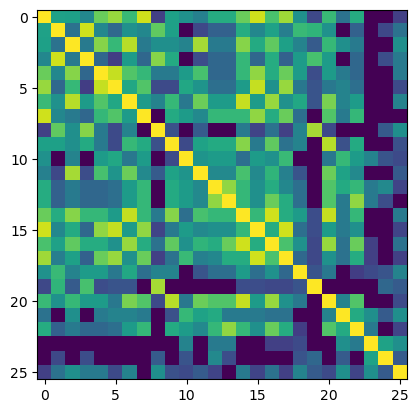

In [9]:
# pairwise 26x26 cosine similarity matrix
sims = cosine_similarity(reps)
plt.imshow(sims)

## Types of masking: occlude top, bottom, left, right (incl/excl midline)

In [40]:
# apply a mask to a representation of a letter 
def mask_char(rep, mask):
    mask_arr = np.ones(14)
    for i in mask:
        mask_arr[i-1] = 0
    return rep * mask_arr

# different types of occlusion masks
mask_bottom = {7,8,9,10,11,12,13,14}
mask_bottom_less = {9,10,11,12,13,14}
mask_bottom_more = {2,3,4,5,6,7,8,9,10,11,12,13,14}
mask_top = {1,2,3,4,5,6,7,8}
mask_right = {4,5,6,8,11,12,13}
mask_left = {2,3,4,7,9,10,11}

# masking the most used segment
mask_most_used = {9}

# masking just the top or bottom line segment (not the whole top or bottom half)
mask_bottom_line = {14}
mask_top_line ={1}

# can define addition masks below ... 

In [39]:
mask_char(get_letter_rep("F"), mask_bottom)

array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [12]:
reps_masked_bottom = np.array([mask_char(get_letter_rep(x), mask_bottom) for x in letters])

In [13]:
reps_masked_top = np.array([mask_char(get_letter_rep(x), mask_top) for x in letters])

In [14]:
reps_masked_right = np.array([mask_char(get_letter_rep(x), mask_right) for x in letters])
reps_masked_left = np.array([mask_char(get_letter_rep(x), mask_left) for x in letters])
reps_masked_most_used = np.array([mask_char(get_letter_rep(x), mask_most_used) for x in letters])

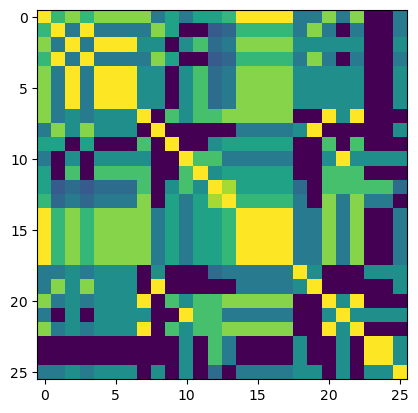

In [15]:
# pairwise cosine similarity matrix when occluding the bottom half of display (including midline)
sims_masked_bottom = cosine_similarity(reps_masked_bottom)
plt.imshow(sims_masked_bottom)

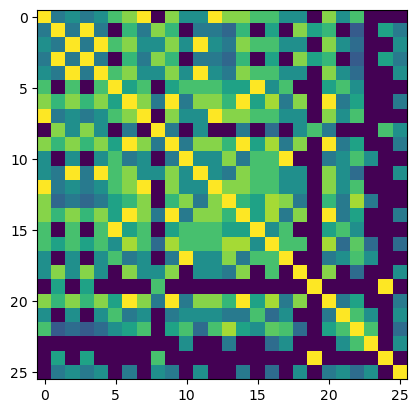

In [16]:
# occluding bottom half of display
sims_masked_top = cosine_similarity(reps_masked_top)
plt.imshow(sims_masked_top)

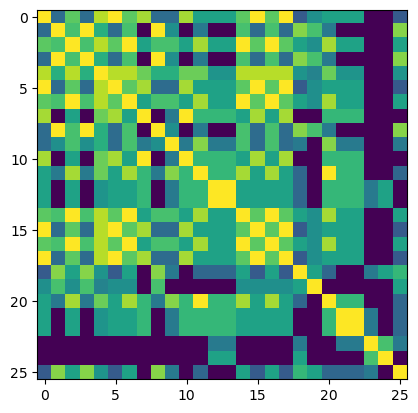

In [17]:
# occluding right half of display
sims_masked_right = cosine_similarity(reps_masked_right)
plt.imshow(sims_masked_right)

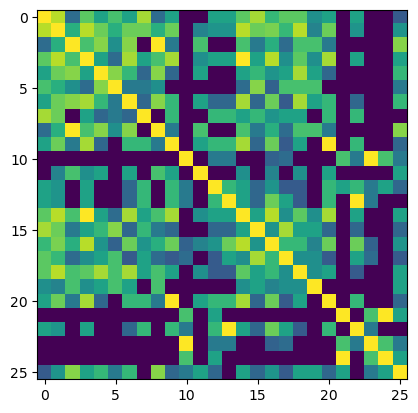

In [18]:
# occluding left half of display
sims_masked_left = cosine_similarity(reps_masked_left)
plt.imshow(sims_masked_left)

In [19]:
reps.mean(axis=0)

array([0.57692308, 0.65384615, 0.19230769, 0.15384615, 0.23076923,
       0.5       , 0.26923077, 0.30769231, 0.69230769, 0.15384615,
       0.19230769, 0.23076923, 0.5       , 0.5       ])

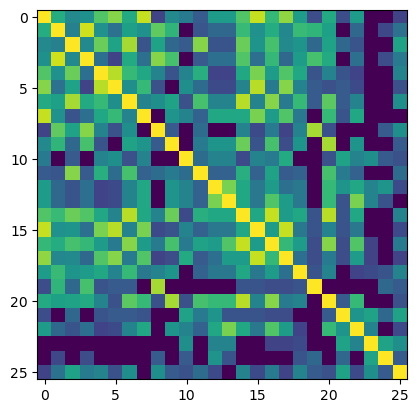

In [20]:
# occluding most frequent segment - bottom left vertical
sims_masked_most_used = cosine_similarity(reps_masked_most_used)
plt.imshow(sims_masked_most_used)

In [41]:
masks = [mask_bottom_more, mask_bottom, mask_bottom_less, mask_bottom_line]

def mask_word(word, mask=1):
    segment_list = []
    for char in word:
        segment_list.append(mask_char(get_letter_rep(char), masks[mask]))
    return segment_list
        

mask_word("FREAK", 1)

[array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]

## Ambiguous letter identification

In [42]:
rep_dicts = []

for mask in [mask_bottom_less]:
    curr_dict = {}
    curr_rep_dict = {}
    for letter in letters:
        set_display = rep_to_display(list(mask_char(get_letter_rep(letter), mask)))
        curr_dict[letter] = set_display
        if tuple(set_display) in curr_rep_dict: 
            curr_rep_dict[tuple(set_display)].append(letter)
        else:
            curr_rep_dict[tuple(set_display)] = [letter]
    rep_dicts.append(curr_rep_dict)

rep_dicts
    

[{(0, 1, 5, 6, 7): ['A', 'P', 'R'],
  (0, 3, 5, 7): ['B'],
  (0, 1): ['C'],
  (0, 3, 5): ['D'],
  (0, 1, 6, 7): ['E', 'F'],
  (0, 1, 7): ['G'],
  (1, 5, 6, 7): ['H'],
  (0, 3): ['I', 'T'],
  (5,): ['J'],
  (1, 4, 6): ['K'],
  (1,): ['L'],
  (1, 2, 4, 5): ['M'],
  (1, 2, 5): ['N'],
  (0, 1, 5): ['O', 'Q'],
  (0, 2, 7): ['S'],
  (1, 5): ['U', 'W'],
  (1, 4): ['V'],
  (2, 4): ['X', 'Y'],
  (0, 4): ['Z']}]

In [46]:
#function that given word, prints existing possibilities for each word
#do people do this sequentially (left to right, or do they take into account realistic words)

def get_possible_words(vertical_occlusion_num, segment_list):
    possible_letters = [[] for x in range(len(segment_list))]
    for segment_id in range(len(segment_list)):
        possible_letters[segment_id] = rep_dicts[vertical_occlusion_num][tuple(rep_to_display(list(segment_list[segment_id])))]
        
    return possible_letters


        
    

In [47]:
print(get_possible_words(1, mask_word("FREAK", 1)))
print(get_possible_words(2, mask_word("FREAK", 2)))
print(get_possible_words(3, mask_word("FREAK", 3)))

[['C', 'E', 'F', 'G'], ['A', 'O', 'P', 'Q', 'R'], ['C', 'E', 'F', 'G'], ['A', 'O', 'P', 'Q', 'R'], ['K', 'V']]
[['E', 'F'], ['A', 'P', 'R'], ['E', 'F'], ['A', 'P', 'R'], ['K']]
[['E', 'F'], ['R'], ['E', 'F'], ['A'], ['K']]


# Ambiguous Words Identification and Presentation Curation for Testing

In [24]:
df = pd.read_excel('SUBTLEXusfrequencyabove1.xls')

df.head(10)

,Word,FREQcount,CDcount,FREQlow,Cdlow,SUBTLWF,Lg10WF,SUBTLCD,Lg10CD
0,the,1501908,8388,1339811,8388,29449.176471,6.176644,100.000000,3.923710
1,to,1156570,8383,1138435,8380,22677.843137,6.063172,99.940391,3.923451
2,a,1041179,8382,976941,8380,20415.274510,6.017526,99.928469,3.923399
3,you,2134713,8381,1595028,8376,41857.117647,6.329340,99.916547,3.923348
4,and,682780,8379,515365,8374,13387.843137,5.834281,99.892704,3.923244
5,it,963712,8377,685089,8370,18896.313725,5.983948,99.868860,3.923140
6,s,1057301,8377,1052788,8373,20731.392157,6.024199,99.868860,3.923140
7,of,590439,8375,573021,8372,11577.235294,5.771176,99.845017,3.923037
8,for,351650,8374,332686,8370,6895.098039,5.546112,99.833095,3.922985
9,I,2038529,8372,5147,350,39971.156863,6.309317,99.809251,3.922881


In [25]:
freq_dict = df.set_index('Word').to_dict()['FREQcount']
print(freq_dict['and'])

682780


In [50]:
occluded_dict = {}
for word in df['Word']:
    if word and str(word) != "nan" and len(word)>3:
        #print(word)
        tuple_word_list = [tuple(rep_to_display(list(mask_char(get_letter_rep(letter.upper()), mask_bottom_less)))) for letter in word]

        
        if tuple(tuple_word_list) in occluded_dict:
            occluded_dict[tuple(tuple_word_list)].append(word)
        else:
            occluded_dict[tuple(tuple_word_list)] = [word]
        
occluded_dict_final = {k:v for (k,v) in occluded_dict.items() if len(v)>1}
sim_displays = list(occluded_dict_final.values())

In [51]:
for listed in sim_displays:
    if max([freq_dict[word] for word in listed]) > 100:
        print(listed)
        print([freq_dict[word] for word in listed])

['that', 'Thai']
[719677, 167]
['more', 'mope']
[66228, 34]
['sure', 'surf', 'Supe']
[56091, 324, 5]
['sorry', 'soapy', 'soppy']
[59566, 25, 6]
['wait', 'writ', 'Watt']
[42343, 88, 96]
['after', 'Peter']
[34812, 4596]
['life', 'lief']
[40629, 8]
['away', 'awry']
[37276, 28]
['hear', 'heap', 'Herr', 'Hera']
[28323, 249, 557, 160]
['their', 'Theta']
[33413, 81]
['care', 'Cape']
[24748, 420]
['trying', 'taxing']
[22849, 15]
['show', 'Shou']
[24906, 7]
['real', 'peal']
[22583, 7]
['ready', 'Perdy']
[19778, 60]
['many', 'Manx']
[18331, 2]
['head', 'herd']
[18947, 360]
['morning', 'moaning']
[22389, 245]
['turn', 'Tuan']
[15630, 18]
['saying', 'spying']
[14874, 279]
['part', 'prat', 'rapt']
[13337, 19, 12]
['happy', 'Harry', 'harpy']
[16993, 4193, 34]
['word', 'Woad']
[12013, 2]
['rest', 'pest']
[10861, 146]
['waiting', 'writing']
[10767, 2852]
['afraid', 'repaid']
[12631, 42]
['reason', 'person', 'Peason']
[9858, 10857, 2]
['eyes', 'exes']
[11299, 14]
['pick', 'Rick']
[10118, 1336]
['half',

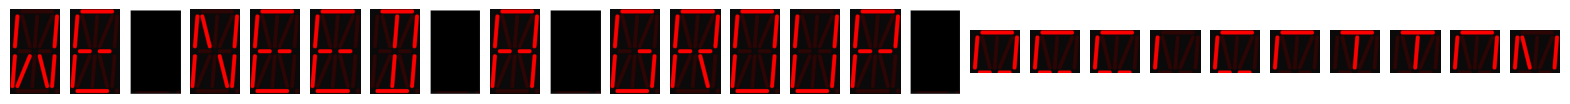

In [104]:
# function to plot a given word
def plot_word_partial_masked(word,  start_mask, end_mask=len(word), level_of_occlusion = 4):
    fig, ax = plt.subplots(1, len(word), figsize=(20, 10))
    
    imageObject = Image.open("digital_chars.gif")
    for i, char in enumerate(word.upper()):
        if char != " ":
            width, height = imageObject.size
            left = 0
            right = width
            top = 0
            #bottom = height/2
            bottom=height
            if i in range(start_mask, end_mask):
                if level_of_occlusion == 3:
                    bottom = height-30
                if level_of_occlusion == 2:
                    bottom=height/2
                if level_of_occlusion == 1:
                    bottom=height/2-30
                if level_of_occlusion == 0:
                    bottom=10
            imageObject.seek(letters.index(char))
            ax[i].imshow(imageObject.crop((left, top, right, bottom)))
            ax[i].axis('off')
        else:
            blankObject = Image.open("blank segment picture.png")
            ax[i].imshow(blankObject)
            ax[i].axis('off')
            
plot_word_partial_masked('we need a group reflection', 'we need a group reflection'.index('reflection'), 26, 2)

THE FOOD DRIES FAST DRIES 9 14
PAINT THE PICTURE PAINT 0 5
YOUR FOAM HELPS YOU FLOAT FOAM 5 9
HERDING EVERYONE INSIDE HERDING 0 7
BUYING SHARES SHARES 7 13
INFLATION ISNT HELPING WAGES WAGES 23 28
SHE WAS SPYING ON US SPYING 8 14
I NEED DENTAL CARE DENTAL 7 13
I NEED SOME SPRAY SPRAY 12 17
THE CORPSE IS DEAD CORPSE 4 10
THE CHARTER PASSED CHARTER 4 11
THE SHIRT HAD DRIP DRIP 14 18
RELAX AND BREATHE RELAX 0 5
I RUSHED INTO THE BUILDING RUSHED 2 8
THE PAIN IS TOO MUCH PAIN 4 8
THE LIONS ARE ROARING ROARING 14 21
THE RACKET WAS LOUD RACKET 4 10
SCOPE THE SITUATION SCOPE 0 5


/var/folders/7v/z00cdktn1vd256t13w0dz0pm0000gn/T/ipykernel_4058/1499864733.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, len(word), figsize=(10, 5))


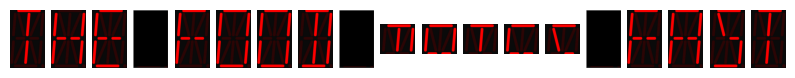

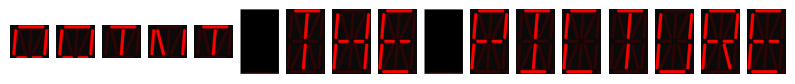

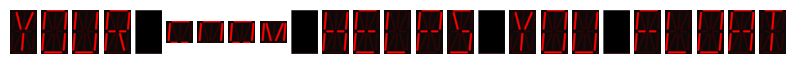

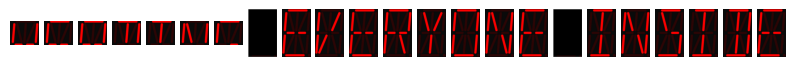

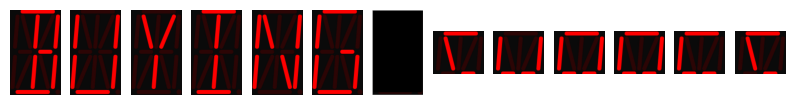

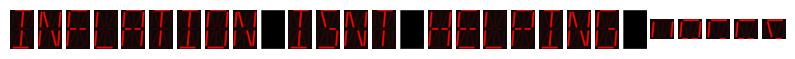

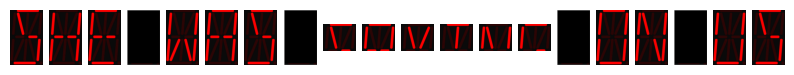

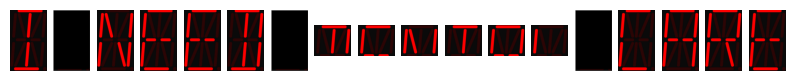

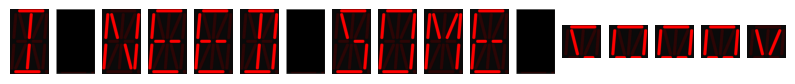

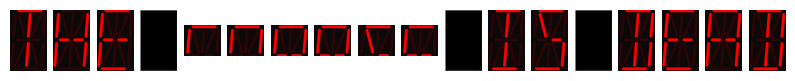

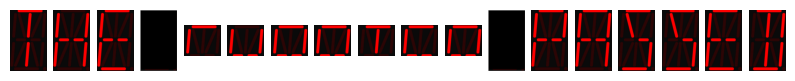

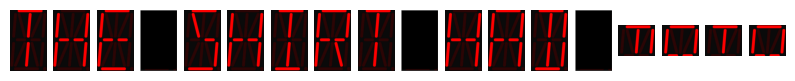

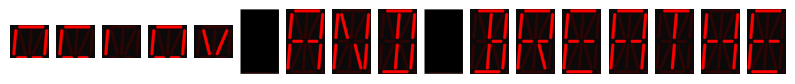

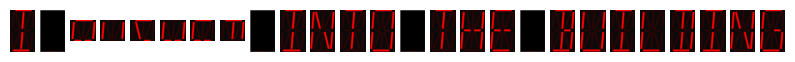

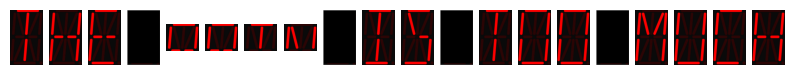

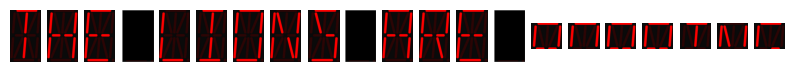

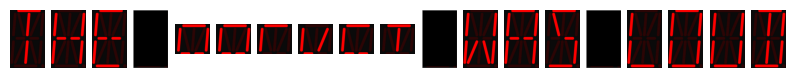

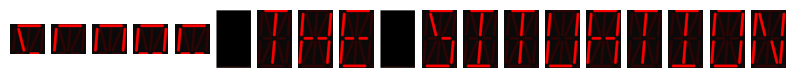

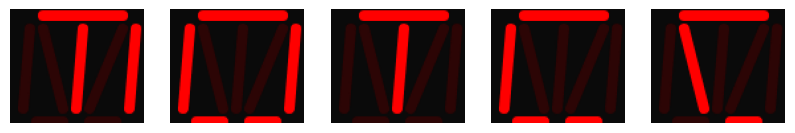

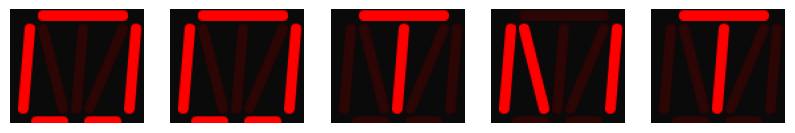

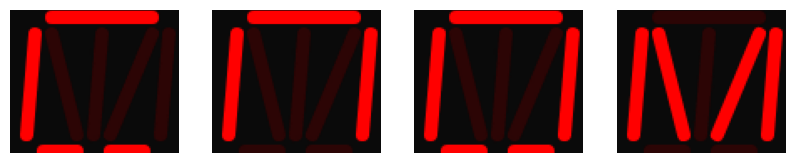

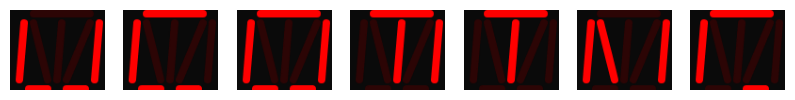

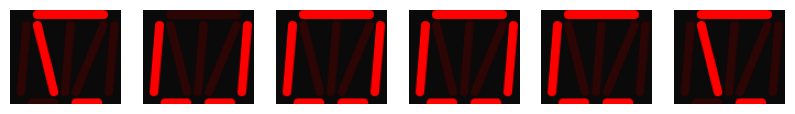

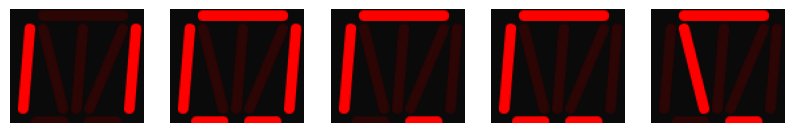

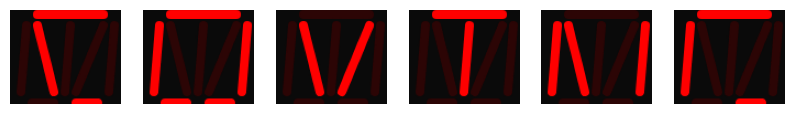

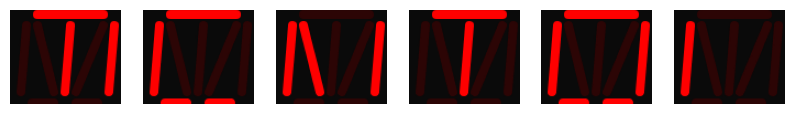

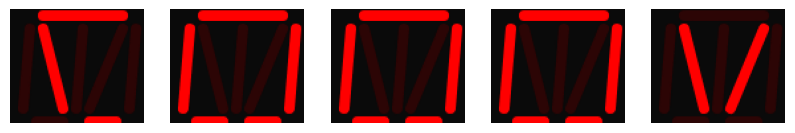

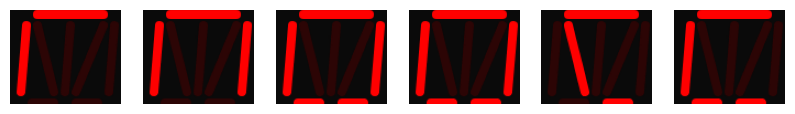

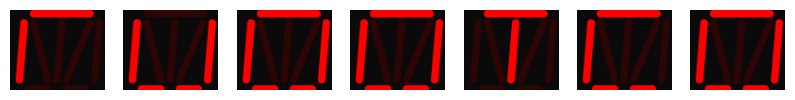

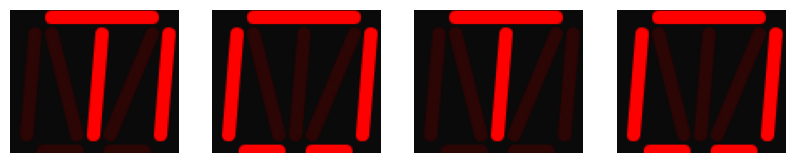

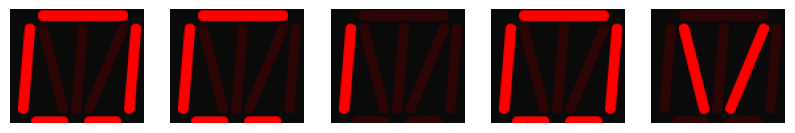

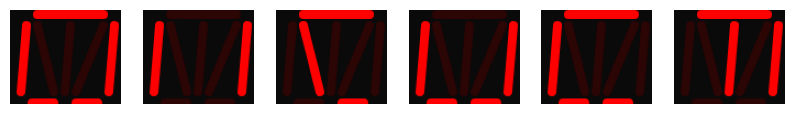

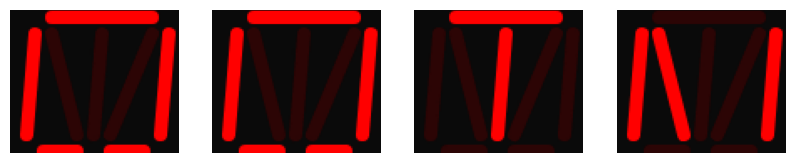

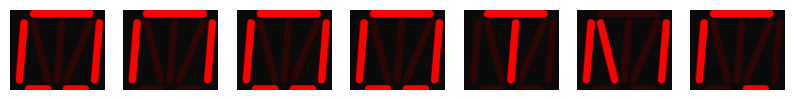

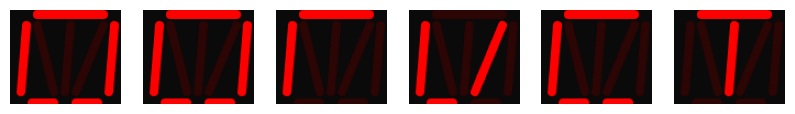

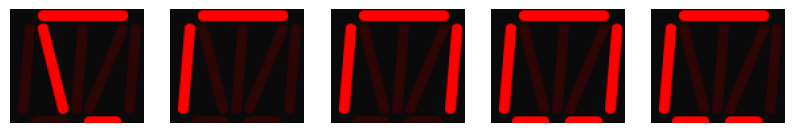

In [55]:
#create presentation of occluded images

imageObject = Image.open("digital_chars.gif")

SLD_LAYOUT_BLANK = 5

phrases = ['THE FOOD DRIES FAST', #[AMBIGUOUS, slightly less pop]
           'PAINT THE PICTURE',  #[slightly pop, ambiguous]
           'YOUR FOAM HELPS YOU FLOAT', #[less pop]
           'HERDING EVERYONE INSIDE', #[less pop]
           'BUYING SHARES', #[more pop]
           'INFLATION ISNT HELPING WAGES', #[slightly pop]
           'SHE WAS SPYING ON US', #[less pop]
           'I NEED DENTAL CARE', #[slightly pop]
           'I NEED SOME SPRAY', #way more pop
           'THE CORPSE IS DEAD', #[more pop]
           'THE CHARTER PASSED', #[less [pop]
           'THE SHIRT HAD DRIP', #way less pop
           'RELAX AND BREATHE', #[way more pop] [pop]
           'I RUSHED INTO THE BUILDING', #ambiguous 
           'THE PAIN IS TOO MUCH', #[more pop]
           'THE LIONS ARE ROARING', #[less pop]
           'THE RACKET WAS LOUD', #way more pop
           'SCOPE THE SITUATION', #less pop
          ] #[AMBIGUOUS]]

words = ['DRIES', 'PAINT', 'FOAM', 'HERDING', 'SHARES', 'WAGES', 
        'SPYING', 'DENTAL', 'SPRAY', 'CORPSE', 'CHARTER', 'DRIP', 
        'RELAX', 'RUSHED', 'PAIN', 'ROARING', 'RACKET', 'SCOPE']

prs_one = Presentation()
#prs_two = Presentation()
#prs_list = [prs_one, prs_two]
blank_layout_one = prs_one.slide_layouts[SLD_LAYOUT_BLANK]
#blank_layout_two = prs_two.slide_layouts[SLD_LAYOUT_BLANK]

for j in range(len(phrases)):
    level_of_occlusion = 2
    
    word = words[j]
    phrase = phrases[j]
    
    start_mask = phrase.index(word)
    end_mask = start_mask + len(word)
    print(phrase, word, start_mask, end_mask)
    fig, ax = plt.subplots(1, len(phrase), figsize=(10, 5))
    for i, char in enumerate(phrase.upper()):
        if char != " ":
            width, height = imageObject.size
            left = 0
            right = width
            top = 0
            #bottom = height/2
            bottom=height
            if i in range(start_mask, end_mask):
                if level_of_occlusion == 3:
                    bottom = height-30
                if level_of_occlusion == 2:
                    bottom=height/2
                if level_of_occlusion == 1:
                    bottom=height/2-30
                if level_of_occlusion == 0:
                    bottom=10
            imageObject.seek(letters.index(char))
            ax[i].imshow(imageObject.crop((left, top, right, bottom)))
            ax[i].axis('off')
        else:
            blankObject = Image.open("blank segment picture.png")
            ax[i].imshow(blankObject)
            ax[i].axis('off')

    slide = prs_one.slides.add_slide(blank_layout_one)
    #slide_two = prs_two.slides.add_slide(blank_layout_two)

    image_stream = io.BytesIO()
    plt.savefig(image_stream)
    pic = slide.shapes.add_picture(image_stream, left=0, top=0)
    
for j in range(len(words)):
    level_of_occlusion = 2
    
    word = words[j]
    
    fig, ax = plt.subplots(1, len(word), figsize=(10, 5))
    for i, char in enumerate(word.upper()):
        if char != " ":
            width, height = imageObject.size
            left = 0
            right = width
            top = 0
            #bottom = height/2
            bottom=height
            if level_of_occlusion == 3:
                bottom = height-30
            if level_of_occlusion == 2:
                bottom=height/2
            if level_of_occlusion == 1:
                bottom=height/2-30
            if level_of_occlusion == 0:
                bottom=10
            imageObject.seek(letters.index(char))
            ax[i].imshow(imageObject.crop((left, top, right, bottom)))
            ax[i].axis('off')
        else:
            blankObject = Image.open("blank segment picture.png")
            ax[i].imshow(blankObject)
            ax[i].axis('off')

    slide = prs_one.slides.add_slide(blank_layout_one)
    #slide_two = prs_two.slides.add_slide(blank_layout_two)

    image_stream = io.BytesIO()
    plt.savefig(image_stream)
    pic = slide.shapes.add_picture(image_stream, left=0, top=0)
        
prs_one.save('occlusion-full-experiment-revised.pptx')
#prs_two.save('occlusion-full-experiment-v2.pptx')

## Word and Letter Frequency Model Creation

In [98]:
words = ['DRIES', 'PAINT', 'FOAM', 'HERDING', 'SHARES', 'WAGES', 
        'SPYING', 'DENTAL', 'SPRAY', 'DATA', 'CHAPTER',  
        'RELAX', 'PUSHED', 'PAIN', 'POPPING', 'RACKET', 'SCORE', 'CORPSE']

words_two = ['DATES', 'PRINT', 'FORM', 'HEADING', 'SHAPES', 'URGES', 
        'SAYING', 'DENIAL', 'SAPPY', 'DRIP',  'CHARTER',  
        'RELAY', 'RUSHED', 'RAIN', 'ROARING', 'PACKET', 'SCOPE', 'COARSE']

occluded_dict = {}
for word in words + words_two:
    if word and str(word) != "nan" and len(word)>3:
        tuple_word_list = [tuple(rep_to_display(list(mask_char(get_letter_rep(letter.upper()), mask_bottom_less)))) for letter in word]
        
        if tuple(tuple_word_list) in occluded_dict:
            occluded_dict[tuple(tuple_word_list)].append(word)
        else:
            occluded_dict[tuple(tuple_word_list)] = [word]
        
occluded_dict_final = {k:v for (k,v) in occluded_dict.items() if len(v)>1}
sim_displays = list(occluded_dict_final.values())

In [52]:
#get word probabilities for each of the two possibilities of words
word_probs = []
for i, words_exp in enumerate(sim_displays):
    freq_list = [freq_dict[word.lower()] for word in words_exp]
    freq_list = [x/sum(freq_list) for x in freq_list]
    print(words_exp)
    print(freq_list)
    word_probs.append(freq_list[words_exp.index(words[i])])
print(word_probs)

['DRIES', 'DATES']
[0.049029622063329927, 0.95097037793667]
['PAINT', 'PRINT']
[0.6483592400690846, 0.35164075993091537]
['FOAM', 'FORM']
[0.07587961000423908, 0.924120389995761]
['HERDING', 'HEADING']
[0.009860788863109048, 0.990139211136891]
['SHARES', 'SHAPES']
[0.7695961995249406, 0.23040380047505937]
['WAGES', 'URGES']
[0.6804123711340206, 0.31958762886597936]
['SPYING', 'SAYING']
[0.018412195604830726, 0.9815878043951692]
['DENTAL', 'DENIAL']
[0.5403087478559176, 0.45969125214408235]
['SPRAY', 'SAPPY']
[0.9196261682242991, 0.08037383177570094]
['DATA', 'DRIP']
[0.8334396936821953, 0.16656030631780472]
['CHAPTER', 'CHARTER']
[0.8, 0.2]
['RELAX', 'RELAY']
[0.970125786163522, 0.029874213836477988]
['PUSHED', 'RUSHED']
[0.7958872810357959, 0.2041127189642041]
['PAIN', 'RAIN']
[0.6669782347442916, 0.33302176525570837]
['POPPING', 'ROARING']
[0.6380510440835266, 0.3619489559164733]
['RACKET', 'PACKET']
[0.747534516765286, 0.252465483234714]
['SCORE', 'SCOPE']
[0.8443960826985855, 0.155

In [36]:
letter_freq_dict = {
    "A": 0.085,
    "B": 0.0207,
    "C": 0.0454,
    "D": 0.0338,
    "E": 0.1116,
    "F": 0.0181,
    "G": 0.0247,
    "H": 0.03,
    "I": 0.0754,
    "J": 0.0020,
    "K": 0.0110,
    "L": 0.0549,
    "M": 0.0301,
    "N": 0.0665,
    "O": 0.0716,
    "P": 0.0317,
    "Q": 0.0020,
    "R": 0.0758,
    "S": 0.0574,
    "T": 0.0695,
    "U": 0.0363,
    "V": 0.0101,
    "W": 0.0129,
    "X": 0.0029,
    "Y": 0.0178,
    "Z": 0.0027
}

In [100]:
rep_dict = {}

mask= mask_bottom_less
for letter in letters:
        set_display = rep_to_display(list(mask_char(get_letter_rep(letter), mask)))
        if tuple(set_display) in rep_dict: 
            rep_dict[tuple(set_display)].append(letter)
        else:
            rep_dict[tuple(set_display)] = [letter]

rep_dict

{(0, 1, 5, 6, 7): ['A', 'P', 'R'],
 (0, 3, 5, 7): ['B'],
 (0, 1): ['C'],
 (0, 3, 5): ['D'],
 (0, 1, 6, 7): ['E', 'F'],
 (0, 1, 7): ['G'],
 (1, 5, 6, 7): ['H'],
 (0, 3): ['I', 'T'],
 (5,): ['J'],
 (1, 4, 6): ['K'],
 (1,): ['L'],
 (1, 2, 4, 5): ['M'],
 (1, 2, 5): ['N'],
 (0, 1, 5): ['O', 'Q'],
 (0, 2, 7): ['S'],
 (1, 5): ['U', 'W'],
 (1, 4): ['V'],
 (2, 4): ['X', 'Y'],
 (0, 4): ['Z']}

In [101]:
# for figure on likelihood of ambiguous letter in occluded word
total_probs = []
for key, value in rep_dict.items():
    if len(value) > 1:
        total_prob = 0
        for letter in value:
            total_prob += letter_freq_dict[letter]
        total_probs.append(total_prob)
print(total_probs)
        

[0.1925, 0.1297, 0.1449, 0.0736, 0.0492, 0.0207]


In [51]:
#creation of letter probability model

letter_probs = []
for j, words_exp in enumerate(sim_displays):
    ind_diff = [i for i in range(len(words_exp[0])) if words_exp[0][i] != words_exp[1][i]]
    
    word_one_prob = 1
    word_two_prob = 1
    
    for ind in ind_diff:
        word_one_prob *= letter_freq_dict[words_exp[0][ind]]
        word_two_prob *= letter_freq_dict[words_exp[1][ind]]
        
    prob_list = [word_one_prob, word_two_prob]
                                          
    prob_list = [x/sum(prob_list) for x in prob_list]
    letter_probs.append(prob_list[words_exp.index(words[j])])
    
print(letter_probs)

['DRIES', 'DATES']
[0.49173264319674564, 0.5082673568032543]
['PAINT', 'PRINT']
[0.5286069651741294, 0.4713930348258707]
['FOAM', 'FORM']
[0.5286069651741294, 0.4713930348258707]
['HERDING', 'HEADING']
[0.4713930348258707, 0.5286069651741294]
['SHARES', 'SHAPES']
[0.7051162790697674, 0.2948837209302325]
['WAGES', 'URGES']
[0.2849502603923036, 0.7150497396076964]
['SPYING', 'SAYING']
[0.27163667523564694, 0.7283633247643531]
['DENTAL', 'DENIAL']
[0.4796411318150449, 0.5203588681849551]
['SPRAY', 'SAPPY']
[0.7051162790697674, 0.2948837209302325]
['DATA', 'DRIP']
[0.7348570774748627, 0.26514292252513727]
['CHAPTER', 'CHARTER']
[0.2948837209302325, 0.7051162790697674]
['RELAX', 'RELAY']
[0.1400966183574879, 0.8599033816425121]
['PUSHED', 'RUSHED']
[0.2948837209302325, 0.7051162790697674]
['PAIN', 'RAIN']
[0.2948837209302325, 0.7051162790697674]
['POPPING', 'ROARING']
[0.06123203733544632, 0.9387679626645538]
['RACKET', 'PACKET']
[0.7051162790697674, 0.2948837209302325]
['SCORE', 'SCOPE']
[

## Results analysis: human performance vs. model performance

In [38]:
#manually calculated

human_results = [0.3333333333, 0.8333333333, 0.5, 0.1666666667, 0.5, 0.3333333333, 0.1666666667, 
                 1, 0.6666666667, 0.6666666667, 0.5,  0.5, 0.6666666667, 0.5, 
                 0.6666666667, 1, 0.8333333333, 0.3333333333]

#imported from HuggingFaceAnalysis.ipynb
gpt_results = [0.9328164473046486, 0.15676460045913107, 0.008775657193753159,
               0.03005990934728687, 0.991496869772301, 0.9999154925853481, 
               0.02137367471566067, 0.9585036020385999, 0.9914305599813296]

gpt_results = [round(x,3) for x in gpt_results]

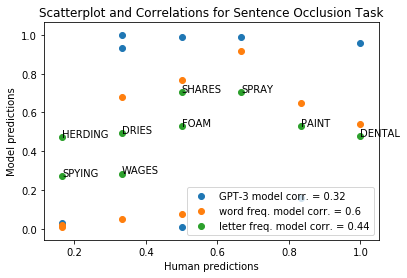

In [63]:
## create plot of all human results - sentences
x = human_results[:9]
y1 = gpt_results
y2 = word_probs[:9]
y3 = letter_probs[:9]
plt.scatter(x, y1, label=f'GPT-3 model corr. = {np.round(np.corrcoef(x,y1)[0,1], 2)}')
plt.scatter(x, y2, label=f'word freq. model corr. = {np.round(np.corrcoef(x,y2)[0,1], 2)}')
plt.scatter(x, y3, label=f'letter freq. model corr. = {np.round(np.corrcoef(x,y3)[0,1], 2)}')

for i, txt in enumerate(words[:9]):
    plt.annotate(words[i], (x[i], y3[i]))

# Plot
plt.title('Scatterplot and Correlations for Sentence Occlusion Task')
plt.xlabel('Human predictions')
plt.ylabel('Model predictions')
plt.legend()
plt.show()


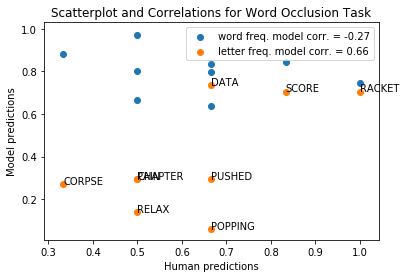

In [64]:
## create plot of all human results - words with no context
x = human_results[9:]
y2 = word_probs[9:]
y3 = letter_probs[9:]
plt.scatter(x, y2, label=f'word freq. model corr. = {np.round(np.corrcoef(x,y2)[0,1], 2)}')
plt.scatter(x, y3, label=f'letter freq. model corr. = {np.round(np.corrcoef(x,y3)[0,1], 2)}')

for i, txt in enumerate(words[9:]):
    plt.annotate(words[9+i], (x[i], y3[i]))

# Plot
plt.title('Scatterplot and Correlations for Word Occlusion Task')
plt.xlabel('Human predictions')
plt.ylabel('Model predictions')
plt.legend()
plt.show()

In [102]:
## create plot of models + human agreement with context
context_ambig = ["PAINT", "DRIES", "FOAM"]
context_slight = ["SHARES", "HERDING"]
context_hard = ["WAGES", "SPYING", "DENTAL", "SPRAY"]

context_ambig = [words.index(x) for x in context_ambig]
context_slight = [words.index(x) for x in context_slight]
context_hard = [words.index(x) for x in context_hard]
context_list = [0 for x in range(9)]

for ind in context_ambig:
    context_list[ind] = 0
for ind in context_slight:
    context_list[ind] = 1
for ind in context_hard:
    context_list[ind] = 2


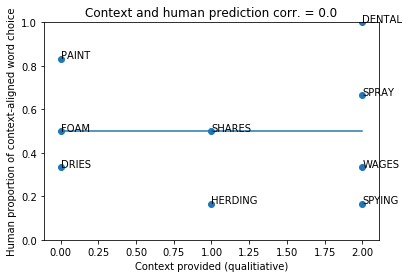

In [95]:
x = human_results[:9]
plt.scatter(context_list, x)

for i, txt in enumerate(words[:9]):
    plt.annotate(words[i], (context_list[i], x[i]))
    
#find line of best fit
a, b = np.polyfit(context_list, x, 1)

#add line of best fit to plot
plt.plot(np.array(context_list), a*np.array(context_list)+b)  

plt.title(f'Context and human prediction corr. = {np.round(np.corrcoef(context_list, x)[0,1], 2)}')
plt.xlabel('Context provided (qualitiative)')
plt.ylabel('Human proportion of context-aligned word choice')
plt.ylim(0,1)
plt.show()